# Datos

In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [10]:
!pip install comet_ml

#import comet_ml at the top of your file
from comet_ml import Experiment

In [2]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Descarga de datos
!kaggle datasets download -d giantuji/UjiIndoorLoc


  0% 0.00/1.51M [00:00<?, ?B/s]
100% 1.51M/1.51M [00:00<00:00, 50.0MB/s]


In [3]:
from zipfile import ZipFile
zip_file = ZipFile('UjiIndoorLoc.zip')
df = pd.read_csv(zip_file.open('TrainingData.csv'))
df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [4]:
df = df[df.BUILDINGID == 0]

In [5]:
df.groupby('FLOOR').count()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
FLOOR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,...,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059,1059
1,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,...,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356,1356
2,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,...,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443,1443
3,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,...,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391,1391


In [6]:
df_X = df.iloc[:,:520]
df_y = df['FLOOR']
print(df_X.shape)

df_X.values[df_X.values==100] = -105

df_X.describe()

(5249, 520)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP481,WAP482,WAP483,WAP484,WAP485,WAP486,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
count,5249.000000,5249.000000,5249.0,5249.0,5249.0,5249.0,5249.000000,5249.000000,5249.000000,5249.0,5249.0,5249.0,5249.000000,5249.000000,5249.0,5249.0,5249.000000,5249.000000,5249.000000,5249.000000,5249.0,5249.0,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.0,5249.0,5249.000000,5249.000000,...,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.000000,5249.0,5249.0,5249.0,5249.0,5249.0,5249.000000,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.000000,5249.0,5249.0,5249.0,5249.0,5249.0,5249.0,5249.000000,5249.0,5249.0,5249.0,5249.000000,5249.0
mean,-104.966851,-104.938083,-105.0,-105.0,-105.0,-105.0,-102.429034,-104.609259,-101.915984,-105.0,-105.0,-105.0,-93.212802,-93.371880,-105.0,-105.0,-104.763574,-104.739760,-102.627739,-102.769289,-105.0,-105.0,-101.136216,-101.104591,-101.726424,-101.622023,-101.149552,-101.004572,-95.611355,-95.484283,-101.430939,-101.395123,-95.262526,-95.264812,-94.128786,-94.175271,-105.0,-105.0,-95.460469,-95.370928,...,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-104.668889,-105.0,-105.0,-105.0,-105.0,-105.0,-104.661269,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-104.965327,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-104.796914,-105.0,-105.0,-105.0,-104.994856,-105.0
std,0.568855,1.034364,0.0,0.0,0.0,0.0,8.242118,2.660245,9.288503,0.0,0.0,0.0,16.669259,16.592314,0.0,0.0,1.945601,2.066008,8.517116,8.321906,0.0,0.0,11.029596,11.041147,9.615999,9.673855,10.594555,10.649254,16.644468,16.567794,10.979724,10.997666,16.527487,16.536925,17.489255,17.335676,0.0,0.0,16.655254,16.563261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.451921,0.0,0.0,0.0,0.0,0.0,2.459417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.705716,0.0,0.0,0.0,0.0,0.0,0.0,1.949022,0.0,0.0,0.0,0.217762,0.0
min,-105.000000,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.0,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,...,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.000000,-105.0
25%,-105.000000,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.0,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.0,-105.0,-105.000000,-105.000000,...,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.0,-105.0,-105.0,-105.000000,-105.0,-105.0,-105.0,-105.000000,-105.0
50%,-105.000000,-105.00000

In [7]:
ap = (df_X.describe().iloc[2]>5).index
values = (df_X.describe().iloc[2]>5).values
ap_buil_2 = [ap[i] for i in range(len(values)) if values[i]==True]
df_X = df_X[ap_buil_2]
print(df_X.shape)
df_X.describe()

(5249, 69)


,WAP007,WAP009,WAP013,WAP014,WAP019,WAP020,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP039,WAP040,WAP041,WAP042,WAP043,WAP044,WAP045,WAP046,WAP047,WAP048,WAP049,WAP050,WAP051,WAP052,WAP053,WAP054,WAP057,WAP058,WAP071,WAP072,WAP075,WAP076,WAP080,WAP081,WAP142,WAP143,WAP154,WAP155,WAP156,WAP161,WAP162,WAP224,WAP225,WAP248,WAP253,WAP268,WAP289,WAP290,WAP294,WAP323,WAP345,WAP346,WAP350,WAP380,WAP401,WAP402,WAP404,WAP434,WAP452
count,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000,5249.000000
mean,-102.429034,-101.915984,-93.212802,-93.371880,-102.627739,-102.769289,-101.136216,-101.104591,-101.726424,-101.622023,-101.149552,-101.004572,-95.611355,-95.484283,-101.430939,-101.395123,-95.262526,-95.264812,-94.128786,-94.175271,-95.460469,-95.370928,-94.424081,-94.263288,-97.190512,-97.034102,-101.866641,-101.791960,-96.224424,-96.180415,-102.742999,-102.682035,-92.244618,-92.465994,-98.828348,-98.788722,-102.395313,-102.294151,-104.101924,-104.060583,-98.921890,-98.827015,-98.164984,-98.097161,-96.871976,-96.612498,-99.098304,-91.663555,-91.478948,-92.115070,-92.363117,-97.162317,-96.606782,-102.422938,-96.514955,-99.503143,-103.076014,-103.810631,-102.115070,-100.357973,-102.895980,-103.502381,-101.989141,-100.507144,-102.932178,-103.796533,-101.772909,-101.545818,-98.217756
std,8.242118,9.288503,16.669259,16.592314,8.517116,8.321906,11.029596,11.041147,9.615999,9.673855,10.594555,10.649254,16.644468,16.567794,10.979724,10.997666,16.527487,16.536925,17.489255,17.335676,16.655254,16.563261,16.634327,16.662724,15.952958,15.955486,9.703990,9.716433,16.104234,16.094780,8.495743,8.458722,16.644152,16.570239,13.848004,13.822872,8.717150,8.782928,5.267655,5.311285,14.514829,14.591548,15.127904,15.130507,15.555700,15.578319,13.394299,17.009871,17.003227,17.314151,17.155216,13.943194,13.784259,7.829805,13.761325,10.444268,6.501270,5.101630,7.699166,9.738701,6.635249,5.727691,7.721801,9.276844,6.469232,5.161542,8.029140,10.410215,12.899220
min,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000
25%,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.000000,-105.0000

In [8]:
df_X.iloc[:,:] = 105 + df_X.values
df_X['FLOOR'] = df_y.values 

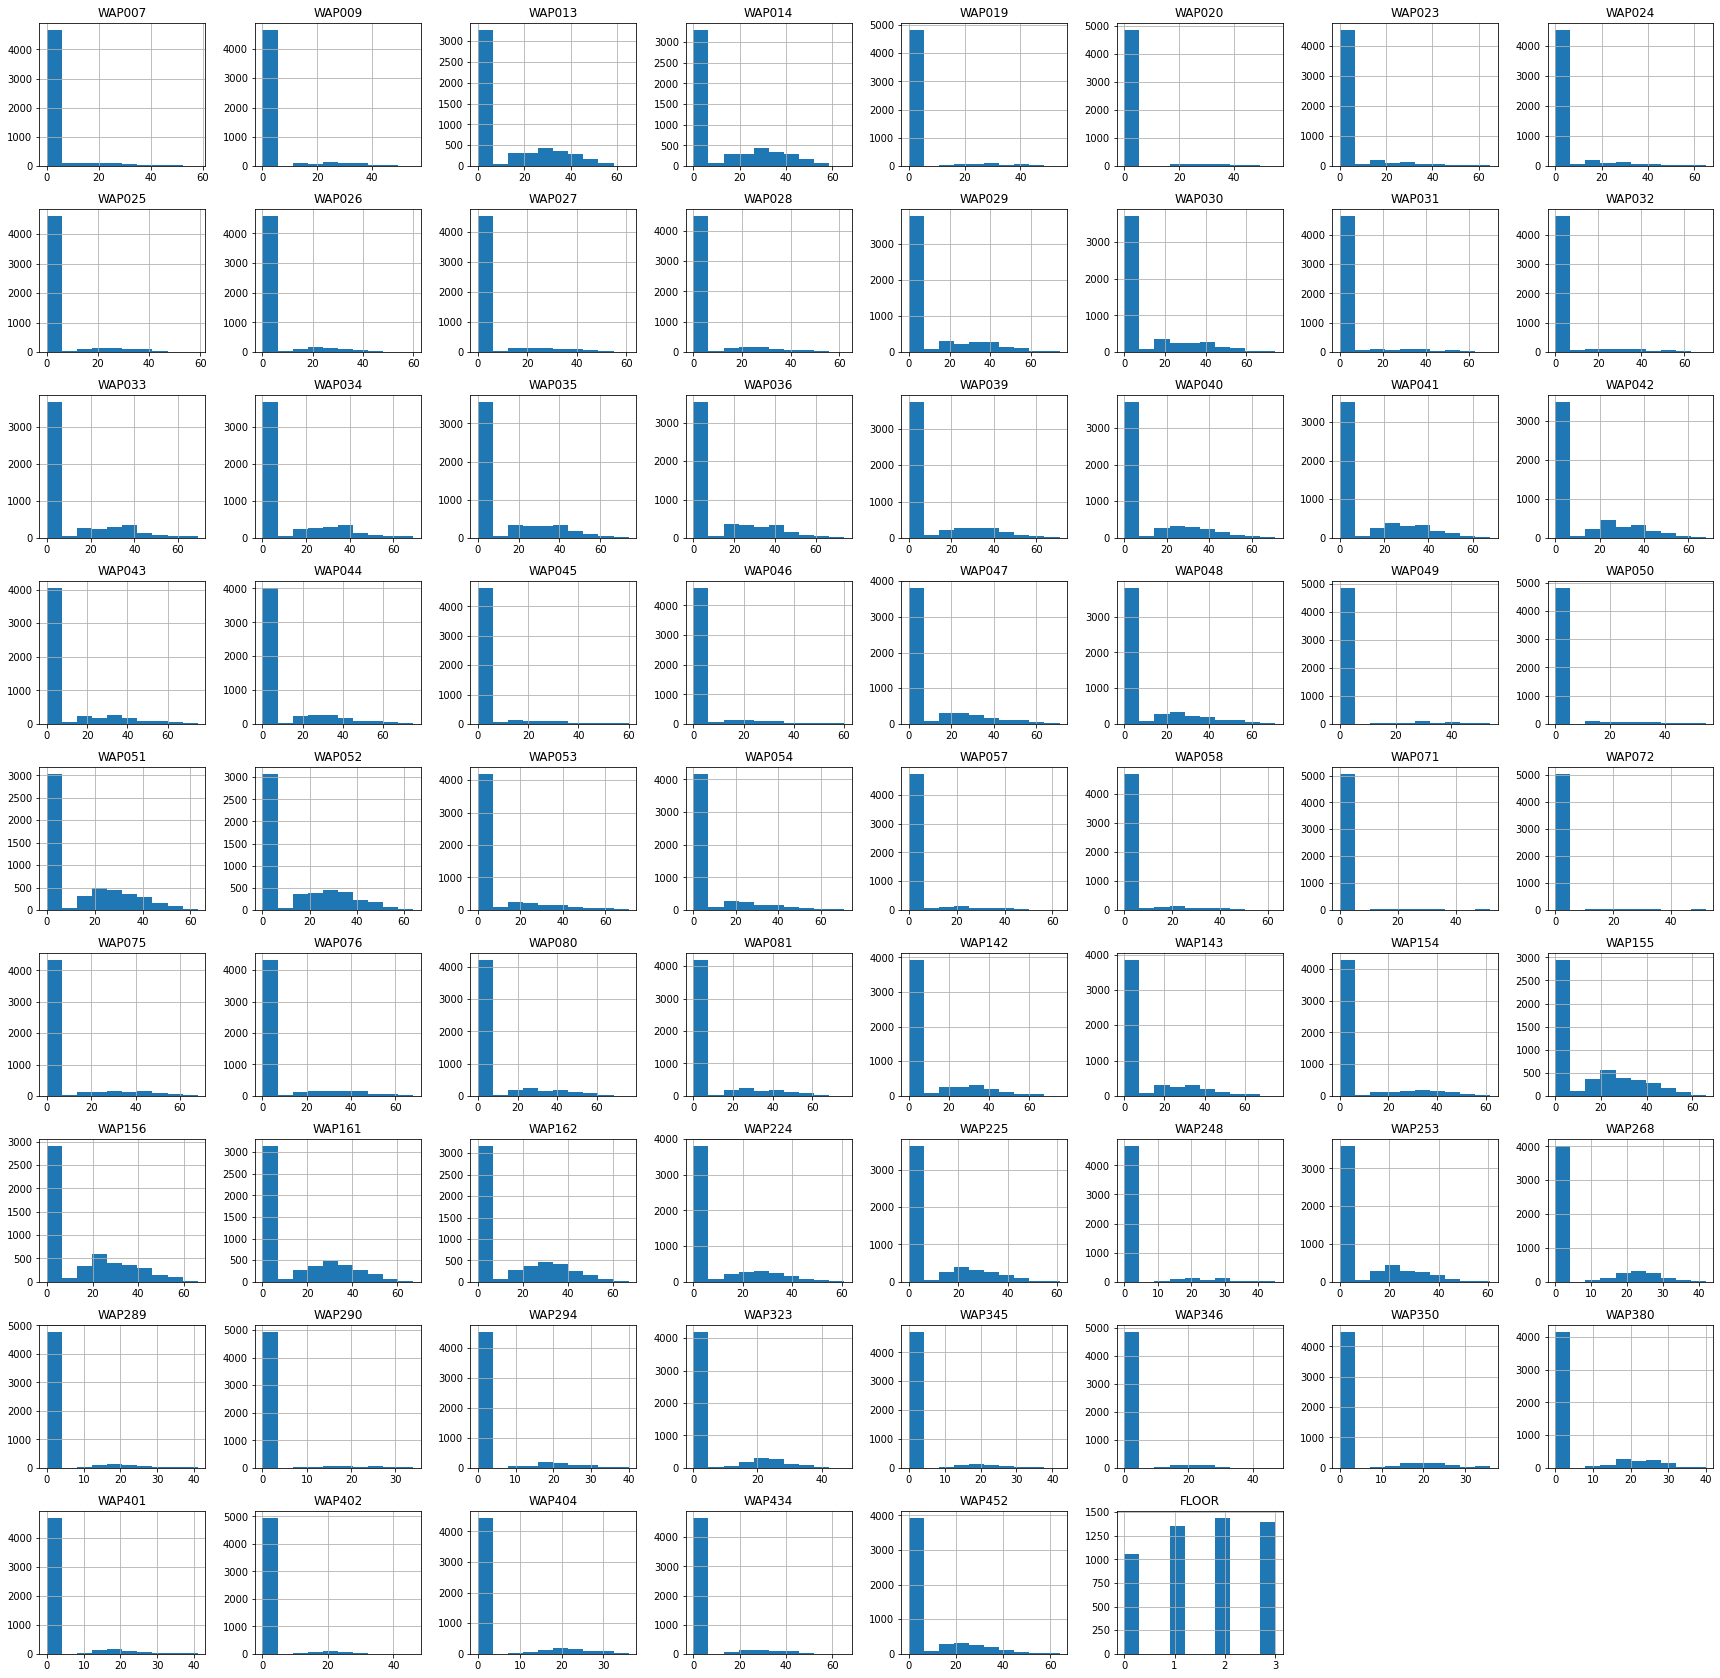

In [9]:
df_X.hist(figsize=[30,30])
plt.show()

In [10]:
import networkx as nx
!git clone https://github.com/alelab-upenn/graph-neural-networks
import sys
sys.path.append('/content/graph-neural-networks/')
#necesita hdf5storage ...
!pip install hdf5storage

import alegnn.modules.architectures as architectures
import alegnn.utils.graphML as graphML
# no sé porqué le cambian los parámetros por defecto a pyplot... por lo menos le saco el latex que en colab no funciona por defecto.
plt.rcParams.update({"text.usetex": False})

import torch

Cloning into 'graph-neural-networks'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 156 (delta 40), reused 48 (delta 19), pack-reused 74
Receiving objects: 100% (156/156), 47.47 MiB | 42.20 MiB/s, done.
Resolving deltas: 100% (68/68), done.
     |████████████████████████████████| 61kB 3.4MB/s 


In [11]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
enc = OrdinalEncoder(dtype=np.int)
y = enc.fit_transform(df_X['FLOOR'].values.reshape(-1,1))
X = df_X.iloc[:,:-1].values

In [12]:
import networkx as nx

def graph_creator(X_G, columns, th=10):
  df_data_train = pd.DataFrame(X_G, columns=columns)
  df_G = pd.DataFrame(columns = ['from', 'to', 'weight']) 

  for i in df_X.columns[:-1]:
    max_val = df_data_train[i].max()
    df_aux_i = df_data_train[df_data_train[i]  > (max_val - th)]
    df_aux_i = df_aux_i.drop(i, axis=1) 
    df_aux_i.head()

  for k, v in df_aux_i.mean().items():
    df_G = df_G.append({'from':i, 'to': k, 'weight': v}, ignore_index=True)

  G = nx.from_pandas_edgelist(df_G, source='from', target='to', edge_attr='weight')  # create_using=nx.DiGraph

  W = nx.to_numpy_array(G)
  # por último le saco la diagonal y la normalizo por su vector propio más grande
  np.fill_diagonal(W,0)
  (w,v) = scipy.sparse.linalg.eigs(W, k=1,which='LM')
  W = W/np.abs(w[0])

  return G, W

In [13]:
def train_model_simple(model, train_data, test_data, batch_size=32, n_epochs=100, epsilon=0.005, weight_decay=1e-2):
    
  optimizer = torch.optim.Adam(model.parameters(), lr=epsilon, weight_decay=weight_decay)

  train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False)
  loss = torch.nn.CrossEntropyLoss()
  for epoch in range(n_epochs):
      for x_batch, y_batch in train_loader:
        if y_batch.shape[0] == batch_size:
          model.zero_grad()
          y_hat = model(x_batch)
          loss_result = loss(y_hat, y_batch.reshape(batch_size).type(torch.long))
          loss_result.backward()
          optimizer.step()
        else:
          break

  for x_batch, y_batch in test_loader:
      y_hattest = model(x_batch)
    
  return (model, y_hattest)

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import scipy
from sklearn.preprocessing import StandardScaler

In [24]:

#Create an experiment with your api key
experiment = Experiment(
    api_key="krnsqImdHJjs4Y1RdFTqfrtjd",
    project_name="aagrafos",
    workspace="facundolezama",
    log_code=True
)

experiment.set_name('ujiindoorloc BUILDING 0')
experiment.add_tag('ujiindoorloc BUILDING 0')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/facundolezama/aagrafos/53756bef937644a4a6cc72c792612ed9



In [15]:
k=5

kf = KFold(n_splits=k)

lr_list = [1e-3, 1e-4]
bs_list = [64, 128] 
wd_list = [1e-3, 1e-4]
n_fil = [1, 3, 5]

param_grid = {'lr': lr_list, 'bs': bs_list, 'wd': wd_list, 'nfil': n_fil}

best_score = 0
best_params = None

columns = df_X.columns[:-1]

nodos = len(columns)

output_len = len(df_X['FLOOR'].value_counts())

epochs = 20

In [26]:
for param in list(ParameterGrid(param_grid)):

  ACC = 0
  for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    Graph, W = graph_creator(X_train_cv[:,:nodos+1], columns, th=10) #el grafo lo armo solo con los datos de 2.4Ghz
    gnn_model = architectures.SelectionGNN(dimNodeSignals=[1, 20, 20], nFilterTaps=[param['nfil'],param['nfil']], bias=True, nonlinearity=torch.nn.ReLU, nSelectedNodes=[nodos, nodos], poolingFunction=graphML.NoPool, poolingSize=[1, 1], dimLayersMLP=[output_len], GSO=torch.from_numpy(W).float())

    scaler = StandardScaler()
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_val_cv = scaler.transform(X_val_cv)

    x_training_data = np.reshape(X_train_cv,(X_train_cv.shape[0],1,nodos))
    x_val_data = np.reshape(X_val_cv,(X_val_cv.shape[0],1,nodos))
    y_training_data = np.reshape(y_train_cv,(y_train_cv.shape[0],1,1))
    y_val_data = np.reshape(y_val_cv,(y_val_cv.shape[0],1,1))

    train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_training_data).float(), torch.from_numpy(y_training_data).float())
    val_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val_data).float(), torch.from_numpy(y_val_data).float())

    trained_gnn_model, y_pred = train_model_simple(gnn_model, train_data, val_data, n_epochs=epochs, epsilon=param['lr'], batch_size=param['bs'], weight_decay=param['wd'])

    m = torch.nn.Softmax(dim=1)
    output = m(y_pred)
    ACC += accuracy_score(y_val_cv, np.array(torch.argmax(output, axis=1)))/k

  if ACC > best_score:
      best_score = ACC
      best_params = param

  print("params: ", param)
  print("Accuracy: ", ACC) 
  print()

print("----------- BEST PARAMS --------------")
print("params: ", best_params)
print("Accuracy: ", best_score) 
print()


experiment.log_parameters({'tag': 'ujiindoorloc BUILDING 0', 'epochs': epochs, 'nodes': nodos, 'class_len': output_len, 'dimNodeSignals':[1, 20, 20]})
experiment.log_parameters(best_params)
experiment.log_metrics({"accuracy_val": best_score})

params:  {'bs': 64, 'lr': 0.001, 'nfil': 1, 'wd': 0.001}
Accuracy:  0.9834265740614645

params:  {'bs': 64, 'lr': 0.001, 'nfil': 1, 'wd': 0.0001}
Accuracy:  0.982854963911208

params:  {'bs': 64, 'lr': 0.001, 'nfil': 3, 'wd': 0.001}
Accuracy:  0.9830456216805121

params:  {'bs': 64, 'lr': 0.001, 'nfil': 3, 'wd': 0.0001}
Accuracy:  0.9834267556402922

params:  {'bs': 64, 'lr': 0.001, 'nfil': 5, 'wd': 0.001}
Accuracy:  0.9834267556402922

params:  {'bs': 64, 'lr': 0.001, 'nfil': 5, 'wd': 0.0001}
Accuracy:  0.9830456216805121

params:  {'bs': 64, 'lr': 0.0001, 'nfil': 1, 'wd': 0.001}
Accuracy:  0.9613247991284217

params:  {'bs': 64, 'lr': 0.0001, 'nfil': 1, 'wd': 0.0001}
Accuracy:  0.9643747787008035

params:  {'bs': 64, 'lr': 0.0001, 'nfil': 3, 'wd': 0.001}
Accuracy:  0.9588496981251986

params:  {'bs': 64, 'lr': 0.0001, 'nfil': 3, 'wd': 0.0001}
Accuracy:  0.95313305188615

params:  {'bs': 64, 'lr': 0.0001, 'nfil': 5, 'wd': 0.001}
Accuracy:  0.9493226201824866

params:  {'bs': 64, 'lr':

# Test

In [16]:
from zipfile import ZipFile
zip_file = ZipFile('UjiIndoorLoc.zip')
df_test = pd.read_csv(zip_file.open('ValidationData.csv'))
df_test.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-91,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,-87,-87,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,-73,-72,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,-77,-75,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,100,100,-79,-79,100,100,100,100,100,100,100,100,-83,-78,100,100,100,100,-62,-62,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [17]:
df_test = df_test[df_test.BUILDINGID == 0]
df_X_test = df_test.loc[:,columns]
df_y_test = df_test['FLOOR']
print(df_X_test.shape)

df_X_test.values[df_X_test.values==100] = -105
df_X_test.iloc[:,:] = 105 + df_X_test.values
df_X_test['FLOOR'] = df_y_test.values 

df_X_test.describe()

(536, 69)


,WAP007,WAP009,WAP013,WAP014,WAP019,WAP020,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP039,WAP040,WAP041,WAP042,WAP043,WAP044,WAP045,WAP046,WAP047,WAP048,WAP049,WAP050,WAP051,WAP052,WAP053,WAP054,WAP057,WAP058,WAP071,WAP072,WAP075,WAP076,WAP080,WAP081,WAP142,WAP143,WAP154,WAP155,WAP156,WAP161,WAP162,WAP224,WAP225,WAP248,WAP253,WAP268,WAP289,WAP290,WAP294,WAP323,WAP345,WAP346,WAP350,WAP380,WAP401,WAP402,WAP404,WAP434,WAP452,FLOOR
count,536.0,536.000000,536.000000,536.000000,536.000000,536.00000,536.00000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.00000,536.000000,536.00000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.00000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.0,536.0,536.0,536.0,536.000000,536.000000,536.000000
mean,0.0,2.813433,8.320896,8.583955,3.203358,3.62500,7.87500,7.707090,4.972015,4.884328,12.595149,12.809701,8.261194,7.916045,8.070896,8.175373,9.776119,9.869403,10.401119,10.591418,8.361940,8.634328,8.917910,9.246269,6.001866,5.809701,4.417910,4.354478,5.572761,5.43097,2.555970,2.88806,10.414179,10.031716,4.699627,4.561567,6.274254,6.457090,3.449627,3.337687,3.608209,3.751866,5.520522,5.748134,6.052239,6.283582,4.45709,10.604478,10.871269,13.725746,13.983209,8.800373,7.779851,2.871269,7.740672,5.861940,3.591418,2.884328,4.145522,5.723881,3.787313,2.145522,3.240672,0.0,0.0,0.0,0.0,0.231343,6.250000,1.479478
std,0.0,8.601602,14.155532,14.018427,9.529181,9.78456,14.23098,14.233895,12.641911,12.554094,18.289017,18.206941,15.147588,15.065913,15.258967,15.394714,16.478427,16.407136,16.160570,15.945205,15.929622,16.224035,15.342104,15.541773,13.946560,13.928696,11.189313,11.121979,12.678863,12.57690,8.308122,8.71815,15.390254,15.160972,11.531723,11.255733,12.472076,12.605963,10.516799,10.114843,10.776898,11.047053,12.828835,13.176657,13.222364,13.349430,10.81268,15.789986,15.832070,16.814029,16.687387,14.567127,13.427690,8.447100,13.350694,10.815166,8.987792,7.543373,8.906435,10.568790,8.797170,6.698954,8.328754,0.0,0.0,0.0,0.0,2.212671,12.350073,0.927034
min,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0

In [19]:
escaler = StandardScaler()
X = escaler.fit_transform(X)

y_test = enc.transform(df_X_test['FLOOR'].values.reshape(-1,1))
X_test = df_X_test.iloc[:,:-1].values
X_test = escaler.transform(X_test)

x_training_data = np.reshape(X,(X.shape[0],1,nodos))
x_test_data = np.reshape(X_test,(X_test.shape[0],1,nodos))
y_training_data = np.reshape(y,(y.shape[0],1,1))
y_test_data = np.reshape(y_test,(y_test.shape[0],1,1))

train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_training_data).float(), torch.from_numpy(y_training_data).float())
test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test_data).float(), torch.from_numpy(y_test_data).float())

In [20]:
Graph, W = graph_creator(X[:,:nodos+1], columns, th=10)

gnn_model = architectures.SelectionGNN(dimNodeSignals=[1, 20, 20], nFilterTaps=[best_params['nfil'],best_params['nfil']], bias=True, nonlinearity=torch.nn.ReLU, nSelectedNodes=[nodos, nodos], poolingFunction=graphML.NoPool, poolingSize=[nodos, nodos], dimLayersMLP=[output_len], GSO=torch.from_numpy(W).float())

(trained_gnn_model, y_hattest) = train_model_simple(gnn_model, train_data, test_data, n_epochs=epochs, epsilon=best_params['lr'], batch_size=best_params['bs'], weight_decay=best_params['wd'])

m = torch.nn.Softmax(dim=1)
output = m(y_hattest)   
ACC_test = accuracy_score(y_test, np.array(torch.argmax(output, axis=1)))

print(ACC_test)

experiment.log_metrics({"accuracy_test": ACC_test})

0.9552238805970149


NameError: ignored

In [ ]:
experiment.end()

# KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier(n_neighbors=15)
param = {'n_neighbors': [5, 10, 15]}

clf_knn= GridSearchCV(neigh, param)
clf_knn.fit(X, y)


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=15, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [5, 10, 15]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [22]:
print(clf_knn.best_params_)
print(clf_knn.best_score_)

{'n_neighbors': 5}
0.9879990921058605


In [23]:
K = clf_knn.best_params_['n_neighbors']
neigh = KNeighborsClassifier(n_neighbors=K)
neigh.fit(X, y)
y_pred_knn = neigh.predict(X_test)

In [24]:
print(accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

0.960820895522388
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        78
           1       0.96      0.97      0.96       208
           2       0.95      0.96      0.95       165
           3       1.00      0.94      0.97        85

    accuracy                           0.96       536
   macro avg       0.96      0.96      0.96       536
weighted avg       0.96      0.96      0.96       536



# FCNN

In [25]:
from sklearn.neural_network import MLPClassifier

In [26]:
clf = MLPClassifier().fit(X, y)
y_pred_fcnn = clf.predict(X_test)

In [27]:
print(accuracy_score(y_test, y_pred_fcnn))
print(classification_report(y_test, y_pred_fcnn))

0.957089552238806
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        78
           1       0.96      0.97      0.96       208
           2       0.95      0.98      0.96       165
           3       1.00      0.93      0.96        85

    accuracy                           0.96       536
   macro avg       0.96      0.95      0.95       536
weighted avg       0.96      0.96      0.96       536

